# Import Libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [133]:
import datetime
import missingno as msno

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox

from scipy.optimize import curve_fit

# Time Series Analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# Accuracy Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Visualization
from plotly.subplots import make_subplots
from plotly.colors import DEFAULT_PLOTLY_COLORS
import plotly.express as px
import plotly.graph_objects as go

import helper


In [3]:
PLOT_WIDTH, PLOT_HEIGHT = (1000, 500)
helper._init()


Misc Folder located!
Plots Folder located!


# Data Preprocessing


## Load Data


In [4]:
google = helper.fetch_data_from_database(
    table="mobility_stats_google",
    where_column="country_region_code",
    where_value="GR",
    order_by="date",
    date_column="date",
)
covid = helper.fetch_data_from_database(table="covid_data_greece", date_column="date")


Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched
Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched


## Data Cleaning


In [5]:
google.columns = [col.removesuffix("_percent_change_from_baseline") for col in google.columns]


<AxesSubplot:>

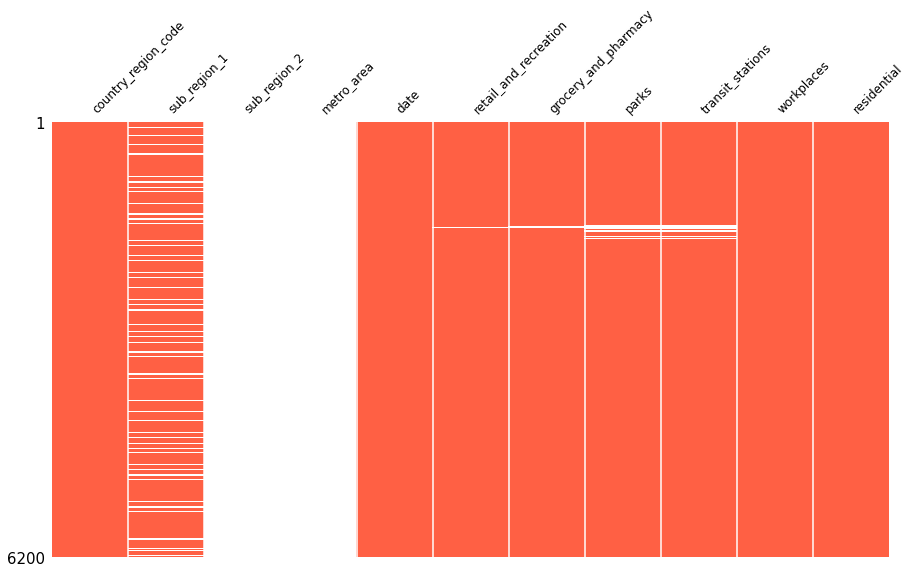

In [6]:
msno.matrix(google, figsize=(15, 8), fontsize=12, sparkline=False, color=(1, 0.38, 0.27))


In [7]:
google.dtypes


country_region_code              object
sub_region_1                     object
sub_region_2                     object
metro_area                       object
date                     datetime64[ns]
retail_and_recreation           float64
grocery_and_pharmacy            float64
parks                           float64
transit_stations                float64
workplaces                      float64
residential                     float64
dtype: object

In [8]:
num_cols = [column for column in google.columns if google[column].dtype == "float64"]
google = helper.preproccess_pipeline(
    df=google, numeric_columns=num_cols, group_subset=["date", "sub_region_1"], threshold=0.8
)


Step 1: Checking for null columns...
--- Found null column: sub_region_2
--- Found null column: metro_area
Step 2: Checking for duplicate entries...
--- No duplicate entries found
Step 3: Dropping samples that have more than 20% missing values
Step 4: Fill remaining null values with forward fill method


In [9]:
# Drop samples with missing location info
google = google[~google["sub_region_1"].isna()]


In [10]:
regions = google.groupby(by="sub_region_1").groups.keys()

# Population per Region as of 2020 stats
regional_pop = [
    3_828_434,
    623_065,
    620_545,
    2_490_290,
    1_465_554,
    1_280_152,
    508_246,
]
total_pop = sum(regional_pop)
weights = {k: v / total_pop for k, v in zip(regions, regional_pop)}


In [11]:
def weighted_mean(row):
    region = row["sub_region_1"]
    row[num_cols] *= weights.get(region, None)
    return row


In [12]:
google = (
    google.apply(lambda row: weighted_mean(row), axis=1)
    .groupby(by="date", as_index=False)
    .sum(numeric_only=True)
)


In [13]:
# Augment data by adding date-specific columns
google["month"] = google["date"].dt.month
google["year"] = google["date"].dt.year
google["day_name"] = google.date.dt.day_name()


## Check skewness of the features


In [14]:
skewed_cols = [col for col in num_cols[:-2] if np.abs(google[col].skew()) > 0.5]


In [15]:
fig = px.histogram(
    data_frame=google,
    x=skewed_cols,
    histnorm="percent",
    nbins=50,
    facet_col="variable",
    facet_col_wrap=2,
    facet_col_spacing=0.03,
    width=600 * len(skewed_cols),
    height=PLOT_HEIGHT * len(skewed_cols) / 2,
)
fig.update_layout(
    showlegend=False,
    bargap=0.2,
    yaxis=dict(title_text="Frequency"),
    title_text="Feature Histogram with skew > 0.5",
    title_x=0.5,
)
fig.update_xaxes(title_text="Value", position=0.5, ticksuffix="%")
fig.update_yaxes(matches=None, showticklabels=True, ticksuffix="%")
fig.for_each_annotation(
    lambda a: a.update(
        text=f'{helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]}: {np.abs(google[a.text.split("=")[-1]].skew()):.2f}'
    )
)

fig.show()
fig.write_image("../plots/Skewed Features (Histogram)(Google).png")


In [16]:
tickvals = range(-100, 350, 50)

fig = px.line(
    data_frame=google,
    x="date",
    y=skewed_cols,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    title="Daily Mobility Profile ",
    labels=dict(value="Change (%)"),
)
fig.add_vrect(
    x0=datetime.datetime(2020, 5, 1),
    x1=datetime.datetime(2020, 9, 1),
    fillcolor="goldenrod",
    opacity=0.2,
    line_width=0,
)
fig.add_vrect(
    x0=datetime.datetime(2021, 5, 1),
    x1=datetime.datetime(2021, 9, 1),
    fillcolor="goldenrod",
    opacity=0.2,
    line_width=0,
)

fig.update_yaxes(tickmode="array", tickvals=list(tickvals), ticktext=list(tickvals))
fig.for_each_annotation(
    lambda a: a.update(
        text=f'{helper.TITLES[google.columns.get_loc(a.text.split("=")[-1]) - 1]}'
    )
)
fig.show()
fig.write_image("../plots/Skewed Features (Line)(Google).png")


## Check Correlations


In [17]:
# To better capture non-linear relationships and reduce effects from outliers we use Spearman's rank correlation
corr = google.iloc[:, 1:-3].corr(method="spearman")

labels = np.where(
    np.abs(corr) > 0.90,
    "VS",
    np.where(
        np.abs(corr) > 0.75,
        "S",
        np.where(np.abs(corr) > 0.55, "M", np.where(np.abs(corr) > 0.30, "W", "")),
    ),
)


In [18]:
fig = px.box(data_frame=google, x=google.columns[1:-3], width=PLOT_WIDTH, height=PLOT_HEIGHT)
fig.show()
fig.write_image("../plots/Boxplot (Google).png")


In [19]:
fig = px.imshow(
    corr,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    text_auto=".2f",
    color_continuous_scale="RdBu_r",
)

fig.update_layout(
    title="Feature Relationships",
    xaxis=dict(tickmode="array", tickvals=corr.columns, ticktext=helper.TITLES, tickangle=-30),
    yaxis=dict(tickmode="array", tickvals=corr.columns, ticktext=helper.TITLES),
)
fig.update_traces(text=labels, texttemplate="%{text}")

fig.show()
fig.write_image("../plots/Feature Correlations.png")


In [20]:
X = "retail_and_recreation"
Y = "transit_stations"
x_index = google.columns.get_loc(X) - 1
y_index = google.columns.get_loc(Y) - 1

fig = px.scatter(
    data_frame=google,
    x=X,
    y=Y,
    title=f"{helper.TITLES[x_index]} vs {helper.TITLES[y_index]}",
    labels={X: helper.TITLES[x_index], Y: helper.TITLES[y_index]},
    width=PLOT_WIDTH,
    height=600,
)
fig.show()
fig.write_image(f"../plots/{helper.TITLES[x_index]} vs {helper.TITLES[y_index]}.png")
del X, Y


In [21]:
x = google["retail_and_recreation"]
y = google["transit_stations"]


In [22]:
def exponential(x, a, b, c):
    return a * np.exp(x * b) + c * x


In [23]:
sorted_x = {x: y for x, y in zip(x, y)}
sorted_x = dict(sorted((k, v) for (k, v) in sorted_x.items()))

x = np.asarray([k for k in sorted_x.keys()])
y = np.asarray([v for v in sorted_x.values()])


In [24]:
pars, cov = curve_fit(f=exponential, xdata=x, ydata=y, p0=[0, 0, 0], bounds=(-np.inf, np.inf))
res = y - exponential(x, *pars)


In [25]:
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{"colspan": 2}, None], [{}, {}]],
    horizontal_spacing=0.02,
    vertical_spacing=0.05,
    subplot_titles=["Exponential Fitting", "Residuals", "Residual Scatterplot"],
)
fig.add_trace(go.Scatter(x=x, y=y, mode="markers", name="Original Data"), row=1, col=1)
fig.add_trace(
    go.Scatter(x=x, y=exponential(x, *pars), mode="lines", name="Fitted Curve", line_width=3),
    row=1,
    col=1,
)
fig.add_trace(go.Scatter(x=x, y=res, mode="markers", showlegend=False), row=2, col=1)
fig.add_trace(go.Histogram(x=res, nbinsx=50, showlegend=False), row=2, col=2)

fig.update_layout(
    width=PLOT_WIDTH * 1.5,
    height=PLOT_HEIGHT * 2,
    title_text="Curve Fitting Results",
    title_x=0.5,
    bargap=0.2,
)
fig.show()
fig.write_image("../plots/Curve Fitting Results (Google).png")


In [26]:
mae = mean_absolute_error(y_true=y, y_pred=exponential(x, *pars))
print(f"MAE: {mae:.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true=y, y_pred=exponential(x, *pars))):.3f}")


MAE: 11.210
RMSE: 17.306


## Focus on Transit Stations


In [27]:
ts_transit = google[["date", "transit_stations"]].copy()
ts_transit.set_index("date", inplace=True)
ts_transit.index.freq = "D"


In [28]:
px.box(
    ts_transit,
    x="transit_stations",
    notched=True,
    labels={"transit_stations": helper.TITLES[3]},
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)


### Boxcox Transformation


In [29]:
ts_transit.loc[:, "transit_stations"] = (
    ts_transit["transit_stations"] + np.abs(ts_transit["transit_stations"].min()) + 1
)
trans, _ = boxcox(x=ts_transit["transit_stations"])
ts_transit.loc[:, "transit_stations"] = trans

del trans


In [30]:
fig = ts_transit["transit_stations"].plot(
    kind="hist",
    nbins=50,
    labels=dict(value=helper.TITLES[3]),
    width=800,
    height=PLOT_HEIGHT,
    title="Data after Box-Cox Transformation",
    backend="plotly",
)
fig.update_layout(showlegend=False, bargap=0.2)
fig.show()
fig.write_image("../plots/Box-Cox.png")


### Seasonal Decomposition


In [31]:
PERIOD = 7

result = seasonal_decompose(x=ts_transit, model="additive", period=PERIOD, two_sided=True)
trend = result.trend.to_frame()
seasonality = result.seasonal.to_frame()
residual = result.resid.to_frame()


In [32]:
fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=["Original Data", "Observed Trend", "Extracted Seasonality", "Residuals"],
    row_heights=[1200 for _ in range(4)],
    vertical_spacing=0.04
)
index = ts_transit.index
fig.add_trace(
    go.Scatter(x=index, y=ts_transit["transit_stations"], mode="lines", name="Observed"),
    row=1,
    col=1,
)

fig.add_trace(go.Scatter(x=index, y=trend["trend"], mode="lines", name="Trend"), row=2, col=1)

fig.add_trace(
    go.Scatter(x=index, y=seasonality["seasonal"], mode="lines", name="Seasonality"),
    row=3,
    col=1,
)

fig.add_trace(
    go.Scatter(x=index, y=residual["resid"], mode="lines", name="Residual"),
    row=4,
    col=1,
)

fig.update_layout(
    showlegend=False,
    title_text="Seasonal Decomposition",
    title_x=0.5,
    title_font=dict(family="Courier New", size=25),
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT * 3,
)
fig.show()
fig.write_image("../plots/Seasonal Decomposition.png")


In [33]:
fig = google.plot(
    kind='box',
    x="month",
    y="transit_stations",
    color="month",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    title="Month-wise Mobility on Public Transport",
    backend='plotly'
)

fig.update_layout(
    showlegend=False,
    xaxis=dict(
        tickmode="array",
        tickvals=list(range(1, 13)),
        ticktext=[datetime.date(2000, i, 1).strftime("%b") for i in range(1, 13)],
        title_text="Month",
    ),
    yaxis=dict(title_text=helper.TITLES[3]),
)

fig.show()
fig.write_image("../plots/Monthly Box Plot.png")


### Check Stationarity


#### Augmented Dickey-Fuller Test


In [124]:
time_series = ts_transit.copy()
d = 0
ts = time_series["transit_stations"] 

while helper.test_stationarity(ts, nlags=d, confidence=0.01):
    ts = ts.diff().dropna()
    d += 1

time_series.loc[:, f"{d}-lag"] = ts
del ts

 > Is the 0-lag data stationary ?
Test statistic = -2.187
P-value = 0.211
Num of Lags = 21.000
Critical values :
	1%: -3.4390641198617864 - The data is not stationary with 99% confidence
 > Is the 1-lag data stationary ?
Test statistic = -5.343
P-value = 0.000
Num of Lags = 20.000
Critical values :
	1%: -3.4390641198617864 - The data is  stationary with 99% confidence


In [125]:
column = f"{d}-lag"

fig = px.line(
    data_frame=time_series,
    y=[
        column,
        time_series[column].rolling(window=PERIOD, center=False).mean(),
        time_series[column].rolling(window=PERIOD, center=False).std(),
    ],
    labels={"date": "Date", "value": "", "variable": ""},
    title="Rolling Statistics for Differenced Time Series",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
)
fig.data[0].name = "raw data"
fig.data[1].name = "rolling mean"
fig.data[2].name = "rolling variance"

fig.show()
fig.write_image("../plots/Rolling Statistics.png")


#### Autocorrelation plots (ACF & PACF)


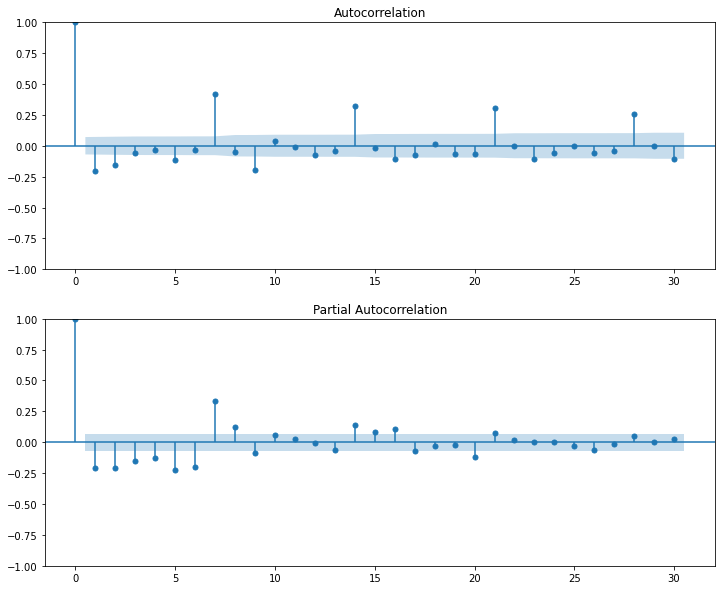

In [128]:
FIG_SIZE = (12, 10)

fig, ax = plt.subplots(2, 1, figsize=FIG_SIZE)
plot_acf(time_series[f"{d}-lag"].dropna(), ax=ax[0], lags=30)
plot_pacf(time_series[f"{d}-lag"].dropna(), ax=ax[1], lags=30, method="ols")
plt.show()


### Building the SARIMA Model


#### Grid Search for optimal parameters


In [129]:
train_size = int(len(time_series) * 0.85)
train_data = time_series[f"{d}-lag"].iloc[:train_size]
test_data = time_series[f"{d}-lag"].iloc[train_size:]


In [120]:
# p = (0, 1, 2, 3)
# d = 1
# q = (0, 1)
# P = (0, 1, 2, 3)
# D = 1
# Q = (0, 1)
# s = (7, 30)

# parameters = product(p, q, P, Q, s)
# parameters_list = list(parameters)

# result_df = helper.optimize_SARIMA(parameters_list, d, D, time_series)


#### Training the optimal SARIMA Model


In [139]:
best_model = SARIMAX(train_data, order=(1, 1, 3), seasonal_order=(1, 1, 3, 7)).fit(disp=False)
print(best_model.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             1-lag   No. Observations:                  658
Model:             SARIMAX(1, 1, 3)x(1, 1, 3, 7)   Log Likelihood                -914.506
Date:                           Sat, 16 Apr 2022   AIC                           1847.013
Time:                                   13:17:47   BIC                           1887.306
Sample:                               02-15-2020   HQIC                          1862.641
                                    - 12-03-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9863      0.020    -49.332      0.000      -1.026      -0.947
ma.L1         -0.3547      0.163     -2.174

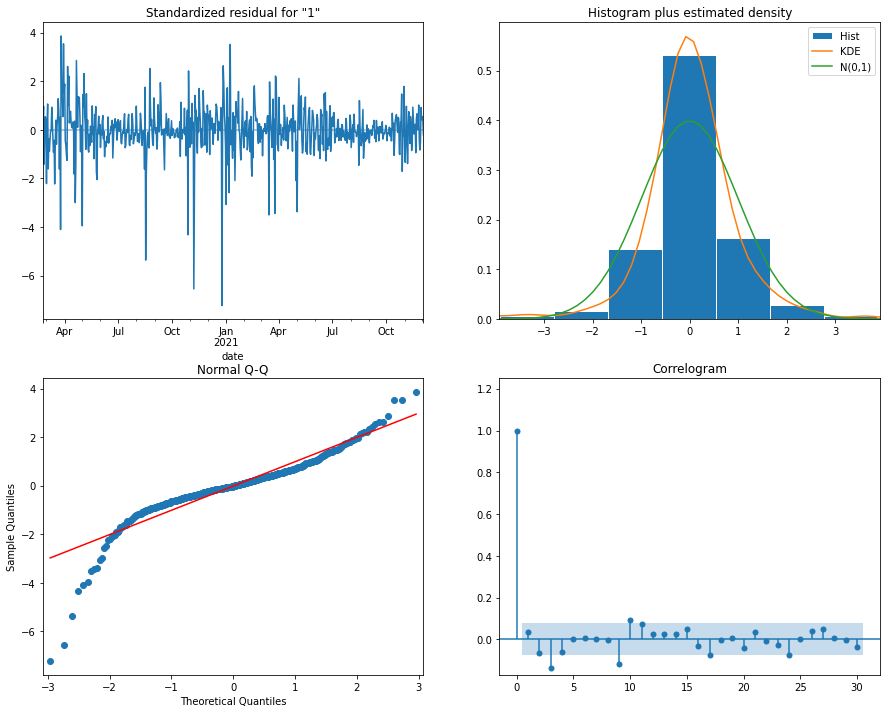

In [122]:
best_model.plot_diagnostics(lags=30, figsize=(15, 12), auto_ylims=True)
plt.show()


In [41]:
predictions, mape_list, forecast_ci = helper.walk_forward_validation(time_series, f"{d}-lag", train_size)


Optimization terminated successfully.
         Current function value: 1.367740
         Iterations: 15
         Function evaluations: 1702
Optimization terminated successfully.
         Current function value: 1.367740
         Iterations: 15
         Function evaluations: 1702
Optimization terminated successfully.
         Current function value: 1.363853
         Iterations: 15
         Function evaluations: 1673
Optimization terminated successfully.
         Current function value: 1.362416
         Iterations: 16
         Function evaluations: 1771
Optimization terminated successfully.
         Current function value: 1.360592
         Iterations: 16
         Function evaluations: 1786
Optimization terminated successfully.
         Current function value: 1.387690
         Iterations: 10
         Function evaluations: 1124
Optimization terminated successfully.
         Current function value: 1.390200
         Iterations: 10
         Function evaluations: 1125
Optimization termina

In [100]:
fig = go.Figure()
fig.add_traces(
    [
        go.Scatter(
            x=train_data.index.values,
            y=train_data,
            mode="lines",
            name="train data",
        ),
        go.Scatter(
            x=test_data.index.values,
            y=test_data,
            mode="lines",
            name="actual values",
            opacity=0.7,
        ),
        go.Scatter(
            x=test_data.index.values,
            y=predictions,
            mode="lines",
            name="predicted values",
            # opacity=0.7,
        ),
    ]
)

fig.update_layout(
    title=f"Forecast until {str(test_data.index[-1].date())}",
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    yaxis_ticksuffix="%",
)
fig.show()
fig.write_image("../plots/Forecast.png")


# Compare behaviour between first and second wave period of the pandemic


In [49]:
covid.iloc[:, 1:] = covid.iloc[:, 1:].diff().astype(pd.Int64Dtype())
# First confirmed case was on 2020-02-26 (at index 35)
covid = covid.loc[35:, :]


In [50]:
fmt = "%Y-%m-%d"  # Specifying the date format

# First Wave
start_date = datetime.datetime.strptime("2020-02-16", fmt)
end_date = datetime.datetime.strptime("2020-06-10", fmt)

mask = (google["date"] >= start_date) & (google["date"] <= end_date)
fw_mobility = google.loc[mask].reset_index(drop=True)
mask = (covid["date"] >= start_date) & (covid["date"] <= end_date)
fw_cases = covid.loc[mask]

# Second Wave
start_date = datetime.datetime.strptime("2020-11-07", fmt)
end_date = datetime.datetime.strptime("2021-03-02", fmt)

mask = (google["date"] >= start_date) & (google["date"] <= end_date)
sw_mobility = google.loc[mask].reset_index(drop=True)
mask = (covid["date"] >= start_date) & (covid["date"] <= end_date)
sw_cases = covid.loc[mask]


## Distributions during each wave


In [159]:
N_BINS = 30

fig = make_subplots(
    rows=1,
    cols=2,
    horizontal_spacing=0.03,
    subplot_titles=["Parks and other Outdoor Spaces", "Transit Stations"]
)
fig.add_trace(
    go.Histogram(
        x=fw_mobility["parks"],
        nbinsx=N_BINS,
        name="first wave",
        marker_color=DEFAULT_PLOTLY_COLORS[0],
        showlegend=True,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Histogram(
        x=sw_mobility["parks"],
        nbinsx=N_BINS,
        name="second wave",
        marker_color=DEFAULT_PLOTLY_COLORS[3],
        showlegend=True,
    ),
    row=1,
    col=1,
)
fig.add_trace(
    go.Histogram(
        x=fw_mobility["transit_stations"],
        nbinsx=N_BINS,
        name="first wave",
        marker_color=DEFAULT_PLOTLY_COLORS[0],
        showlegend=False,  # Hide color legend
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Histogram(
        x=sw_mobility["transit_stations"],
        nbinsx=N_BINS,
        name="second wave",
        marker_color=DEFAULT_PLOTLY_COLORS[3],
        showlegend=False,  # Hide color legend
    ),
    row=1,
    col=2,
)

fig.update_layout(
    title_text="Mobility change between first and second wave",
    title_x=0.5,
    bargap=0.2,
    yaxis_title_text="Frequency",
    width=1500,
    height=600,
)
fig.update_xaxes(title_text="Change (%)")
fig.update_yaxes(matches=None, showticklabels=True, ticksuffix="%")

fig.show()
fig.write_image("../plots/First vs Second Wave.png")

In [149]:
print(fw_cases["confirmed"].sum(), sw_cases.iloc[:42, 1].sum())


3068 77330
